In [1]:
import json
from pathlib import Path
import pdb

import pybo
from pybo import *

print(pybo.VERSION)

0.6.0


## Load lighttag data

In [24]:
paths = [Path('data/ner-lists-87_citations-1000_khar_annotations.json'), Path('data/ner-lists-87_citations-1000_tsering_annotations.json')]

In [25]:
json_01 = json.load(paths[0].open())

In [26]:
example_text = json_01['result'][0]['example']['content']
example_text

'བྱམས་པའི་ཁང་བརྩེགས་རྣམ་དཔྱོད་བློ་གྲོས་ཆེ། །བ་གམ་ཆེར་གསལ་རྣམ་མང་རྒྱལ་སྲས་ཀྱི། །དཀྱིལ་འཁོར་དབུས་ན་མཁས་པའི་རོལ་རྩེད་མཁན། །ཕྱོགས་ལས་རྣམ་རྒྱལ་དབྱིག་གི་གཉེན་ཁྱོད་རྒྱལ། །འདིར་ནི་ཆོས་མངོན་གཞུང་བརྒྱའི་དཔྱིད། །མངོན་སུམ་མཐོང་ནས་གཞན་དག་གིས། །སྙིང་གི་བཅུད་དུ་མ་མྱངས་གཏམ། །ལེགས་བཤད་གསར་པའི་ཁུ་བ་ཐིགས། །སྐལ་བཟང་རྣམ་དཔྱོད་ལྕེ་ལ་རོལ། །མྱོང་བར་འདོད་པས་དགའ་དང་བདེ། །སྤྲོ་བ་ཆེན་པོས་འདི་ལོང་ལ། །མཁས་པའི་མདུན་སར་ངོམ་པར་མཛོད། །ཅེས་བརྗོད་ནས། འདིར་ཆོས་མངོན་པ་མཛོད་ལ་ཉེ་བར་མཁོ་བའི་སྤང་བྱ་སྤོང་ཚུལ་གྱི་གནད་ཟབ་མོ་འཆད་པར་བྱེད་པ་ལ། དངོས་དང་། ཞར་བྱུང་ཉོན་མོངས་ཅན་མ་ཡིན་པའི་མི་ཤེས་པ་སྤོང་ཚུལ་ལོ། །དང་པོ་ལ། ཐར་ལམ་ལ་མ་ཞུགས་པའི་སྐབས་སུ་སྤོང་ཚུལ་དང་། ཐར་ལམ་ལ་ཞུགས་ནས་སྤོང་ཚུལ་གཉིས། དང་པོ་ལ། མདོར་བསྟན་པ་དང་། རྒྱས་པར་བཤད་པ་གཉིས། དང་པོ་ནི། མཛོད་ལས། {++~~++}ས་གསུམ་ལས་རྒྱལ་བསམ་གཏན་ནམ། །ཉེར་བསྡོགས་ལས་མཐའི་རྣམ་གྲོལ་ལམ། །གོང་མའི་ཉེ་བར་བསྡོགས་ལས་མིན། །{++~~++}ཞེས་པའི་གཞུང་ལྟར་བཤད་ན། བསམ་གཏན་དང་པོའི་ཉེར་བསྡོགས་ལ་བརྟེན་ནས་འདོད་པའི་ཉོན་མོངས་ལས་རྒྱལ་བ་དང་། བསམ་གཏན་གཉིས་པའི་ཉེར་བསྡོགས་ལ་བརྟེན་ནས་བསམ་གཏན་དང་པོའི་ཉོན་མོངས་ལས་རྒྱལ་བ་དང་། བསམ་གཏན

In [87]:
# example = [sentence, [(tag, start, end), ...]]

def get_sentence(ann, example_text, tag):
    if tag == 'དབྱེ་བ།' and not '{++~~++}' in example_text: return example_text
    
    sentence = example_text[ann['start']-100: ann['end']+100]
    # right offset
    sentence = sentence[sentence.find(' ')+1:]
    
    #left offset
    left_offset = 0 if sentence.endswith('།') else ("".join(reversed(sentence))).find(' ') + 1   
    sentence = sentence[:len(sentence) - left_offset]
    sentence = sentence.replace('{++~~++}', '')
    return sentence

def get_examples(result):
    example_text = result['example']['content']
    annotations = result['results']['annotations']
    
    examples = []
    for ann in annotations:
        if ann['tag'] == 'ལུང་ཚིག་དངོས།' or ann['tag'] == 'དབྱེ་བ།':
            #pdb.set_trace()
            sentence = get_sentence(ann, example_text, ann['tag'])
            start = ann['start']

            #create new start and end indices
            example = [sentence, []]
            for ann in annotations:
                if abs(ann['start'] - start) > 50: continue
                value = ann['value'].replace('{++~~++}', '')
                value = value[:-1] if value[-1] == ' ' else value
                
                n_start = sentence.find(value)
                if n_start == -1: continue
                if ann['tag'] == 'ལུང་ཁུངས།':
                    idx = value.find('ལས།')
                    if idx != -1:
                        value = value[:idx]
                        n_end = n_start + len(value) - 1
                    else:
                        n_end = n_start + len(value) - 1
                elif ann['tag'] == 'ལུང་དེའི་མཛད་པ་པོ།':
                    idx = value.find('པས།')
                    if idx != -1:
                        value = value[:idx]
                        n_end = n_start + len(value) - 1
                    else:
                        n_end = n_start + len(value) - 1
                else:
                    n_end = n_start + len(value) - 1        
                example[1].append((ann['tag'], n_start, n_end, value))
            
            if len(example[1]) > 1:
                examples.append(example)
                
    return examples

In [63]:
examples = get_examples(json_01['result'][0])
examples

[['རྣམ་པ་ལྔའི་བར་བཅོམ་པ། །གཉིས་པ་ལ་ནི་ཞུགས་པའང་ཡིན། ཞེས་དང་། རང་འགྲེལ་ལས། འབྲས་བུ་ལ་གནས་པ་གང་ཞིག་རྣམ་པ་གཅིག་ནས་ལྔའི་བར་སྤངས་པ་ཡིན་ན། འབྲས་བུ་གཉིས་པ་ལ་ཞུགས་པ་ཡིན་པར་རིག་པར་བྱའོ། །ཞེས་དང་། ཕྱིར་མི་འོང་ཞུགས་པ་འཇོག་པའི་ཚེ། ཉེས་ཆ་བདུན་ནམ་བརྒྱད་ཟད་པ།',
  [('ལུང་ཚིག་དངོས།',
    71,
    174,
    'འབྲས་བུ་ལ་གནས་པ་གང་ཞིག་རྣམ་པ་གཅིག་ནས་ལྔའི་བར་སྤངས་པ་ཡིན་ན། འབྲས་བུ་གཉིས་པ་ལ་ཞུགས་པ་ཡིན་པར་རིག་པར་བྱའོ། །'),
   ('ལུང་ཁུངས།', 58, 66, 'རང་འགྲེལ་')]],
 ['།ཚེ་གཅིག་བར་ཆད་གཅིག་པ་དང་། །གསུམ་པ་ལ་ནི་ཞུགས་པའང་ཡིན། །ཞེས་དང་། རང་འགྲེལ་ལས། རྣམ་པ་བདུན་དང་བརྒྱད་སྤངས་པ་དེ་ནི་འབྲས་བུ་གསུམ་པ་ལ་ཞུགས་པ་ཡིན་པར་རིག་པར་བྱའོ། །ཞེས་དང་། དགྲ་བཅོམ་ཞུགས་པ་འཇོག་པའི་ཚེ། །སྲིད་རྩེའི་བར་ཆ་བརྒྱད་ཟད་པ།',
  [('ལུང་ཁུངས།', 64, 72, 'རང་འགྲེལ་'),
   ('ལུང་ཚིག་དངོས།',
    77,
    154,
    'རྣམ་པ་བདུན་དང་བརྒྱད་སྤངས་པ་དེ་ནི་འབྲས་བུ་གསུམ་པ་ལ་ཞུགས་པ་ཡིན་པར་རིག་པར་བྱའོ། །')]],
 ['དང་པོ་ལ། མདོར་བསྟན་པ་དང་། རྒྱས་པར་བཤད་པ་གཉིས། དང་པོ་ནི། མཛོད་ལས། ས་གསུམ་ལས་རྒྱལ་བསམ་གཏན་ནམ། །ཉེར་བསྡོགས་ལས་མཐའི་རྣམ་གྲོལ་ལམ། །གོང་མའི་ཉེ་བར་བསྡོགས་ལས་མིན། །ཞེས་པའི་ག

In [64]:
get_examples(json_01['result'][1])

[['འདུས་བྱས་ཐམས་ཅད་ནི་འཇིག་པའི་ཆོས་ཅན་ཡིན་ཏེ། ཆེད་དུ་བརྗོད་པའི་ཚོམ་ལས། ཀྱེ་མ་འདུས་བྱས་རྣམས་མི་རྟག །སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑ཞེས་དང༌། གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་པས། ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ།',
  [('ལུང་ཚིག་དངོས།',
    68,
    126,
    'ཀྱེ་མ་འདུས་བྱས་རྣམས་མི་རྟག །སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑'),
   ('ལུང་ཁུངས།', 43, 63, 'ཆེད་དུ་བརྗོད་པའི་ཚོམ་')]],
 ['།སྐྱེ་ཞིང་འཇིག་པའི་ཆོས་ཅན་ཡིན༑ ༑ཞེས་དང༌། གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་པས། ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ། །ནམ་མཁའི་སྤྲིན་བཞིན་འདུས་ཤིང་གྱེས། །བདེན་མེད་སྒྱུ་མའི་ཆོས་རྣམས་ལ། །བདེན་པར་བཟུང་བས་བསླུས་པ་ཡིན། །ཞེས་གསུངས།',
  [('ལུང་དེའི་མཛད་པ་པོ།', 41, 67, 'གྲུབ་ཆེན་ཁྱུང་པོ་རྣལ་འབྱོར་'),
   ('ལུང་ཚིག་དངོས།',
    72,
    195,
    'ཀྱེ་མ་འདུས་བྱས་མི་རྟག་སྟེ། །ནམ་མཁའི་སྤྲིན་བཞིན་འདུས་ཤིང་གྱེས། །བདེན་མེད་སྒྱུ་མའི་ཆོས་རྣམས་ལ། །བདེན་པར་བཟུང་བས་བསླུས་པ་ཡིན། །')]]]

In [65]:
get_examples(json_01['result'][2])

[['བདག་གི་ལུས་ངག་ཡིད་གསུམ་བསྡམས་ནས་དུལ་བ་དང་ལྡན་པས་གཞན་ཡང་དུལ་བར་བྱེད་ནུས་ཏེ། མདོ་ལས། བདག་མ་གྲོལ་བས་སེམས་ཅན་གཞན་གྲོལ་བར་མི་ནུས་ལ། དེ་བཞིན་བདག་མ་ཞི་ན་གཞན་ཞི་བ་དང༌། བདག་མ་དུལ་ན་གཞན་དུལ་བར་བྱ་མི་ནུས་སོ་ཞེས་གསུངས་པ་བཞིན་ནོ།',
  [('ལུང་ཁུངས།', 75, 78, 'མདོ་'),
   ('ལུང་ཚིག་དངོས།',
    83,
    195,
    'བདག་མ་གྲོལ་བས་སེམས་ཅན་གཞན་གྲོལ་བར་མི་ནུས་ལ། དེ་བཞིན་བདག་མ་ཞི་ན་གཞན་ཞི་བ་དང༌། བདག་མ་དུལ་ན་གཞན་དུལ་བར་བྱ་མི་ནུས་སོ་')]]]

In [66]:
get_examples(json_01['result'][3])

[['བྱང་ཕྱོགས་ན་ནི་ཉེས་དམིགས་ལྔ་ཡོད་དེ། མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །',
  [('དབྱེ་གཞི།', 15, 24, 'ཉེས་དམིགས་'),
   ('དབྱེ་བ།',
    36,
    174,
    'མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །')]]]

In [88]:
get_examples(json_01['result'][49])

[['སྡུད་པ་ལས། མི་ཁོམ་བརྒྱད་སྤངས་དེ་ཡི་དལ་བ་རྟག་ཏུ་རྙེད༑ ༑ཅེས་གསུངས། འབྱོར་པ་བཅུ་ལས། རང་འབྱོར་ལྔ་ནི། མི་ཉིད་དབུས་སྐྱེས་དབང་པོ་ཚང༌༑',
  [('ལུང་ཚིག་དངོས།', 11, 53, 'མི་ཁོམ་བརྒྱད་སྤངས་དེ་ཡི་དལ་བ་རྟག་ཏུ་རྙེད༑ ༑'),
   ('ལུང་ཁུངས།', 0, 6, 'སྡུད་པ་')]],
 ['དེ་ལྟར་མ་འབད་ན་འདི་ལས་བསླུས་པ་གཞན་མེད་སྙམ་དུ་བསམ་པར་བྱ་སྟེ། སྤྱོད་འཇུག་ལས། འདི་འདྲའི་དལ་བ་རྙེད་གྱུར་ནས། །བདག་གིས་དགེ་གོམས་མ་བྱས་ན། །འདི་ལས་བསླུས་པ་གཞན་མེད་དེ། །འདི་ལས་རྨོངས་པ་གཞན་མེད་དོ། །ཞེས་གསུང་པ་བཞིན་ནོ། །',
  [('ལུང་ཁུངས།', 59, 70, ' སྤྱོད་འཇུག་'),
   ('ལུང་ཚིག་དངོས།',
    75,
    187,
    'འདི་འདྲའི་དལ་བ་རྙེད་གྱུར་ནས། །བདག་གིས་དགེ་གོམས་མ་བྱས་ན། །འདི་ལས་བསླུས་པ་གཞན་མེད་དེ། །འདི་ལས་རྨོངས་པ་གཞན་མེད་དོ། །')]],
 ['ལྔ་པོ་ནི་རང་རྒྱུད་ཀྱིས་བསྡུས་ཤིང་ཆོས་སྒྲུབ་པའི་ཆ་རྐྱེན་ཡིན་པས་རང་འབྱོར་ཞེས་བྱ། གཞན་འབྱོར་ལྔ་ནི། སངས་རྒྱས་བྱོན་དང་དེས་ཆོས་གསུངས། །བསྟན་པ་གནས་དང་དེ་རྗེས་འཇུག །གཞན་ཕྱིར་སྙིང་ནི་བརྩེ་བའོ། །ཞེས་པས། སངས་རྒྱས་འཇིག་རྟེན་དུ་བྱོན་དེས་དམ་པའི་ཆོས་གསུངས། དེའི་བསྟན་པ་མ་ནུབ་པར་གནས།',
  [('དབྱེ་བ།',
    96,
    184,
    'སངས་རྒྱས་བྱོན་དང་དེས་ཆོས་

In [98]:
get_examples(json_01['result'][245])

[['།ཞེས་དང༌། ཇོ་བོའི་བླ་མ་གསེར་གླིང་པ་ཆེན་པོས་བློ་སྦྱོང་སེམས་པའི་རིམ་པ་ལས། བདེ་གཤེགས་ལམ་སྲོལ་སྐྱོང་བའི་ཕྱིར། །རྒྱལ་པོ་སྙིང་སྟོབས་ཆེན་པོ་ལྟར། །གཞན་དོན་འབའ་ཞིག་རབ་བསམ་ནས། །བདག་གཞན་ངེས་པར་བརྗེ་བར་བྱ། །ཞེས་དང༌། སློབ་དཔོན་དྷརྨ་རཀྵི་ཏས་བློ་སྦྱོང་རྨ་བྱ་དུག་འཇོམས་ལས།',
  [('ལུང་ཚིག་དངོས།',
    72,
    194,
    'བདེ་གཤེགས་ལམ་སྲོལ་སྐྱོང་བའི་ཕྱིར། །རྒྱལ་པོ་སྙིང་སྟོབས་ཆེན་པོ་ལྟར། །གཞན་དོན་འབའ་ཞིག་རབ་བསམ་ནས། །བདག་གཞན་ངེས་པར་བརྗེ་བར་བྱ། །'),
   ('ལུང་ཁུངས།', 43, 67, 'བློ་སྦྱོང་སེམས་པའི་རིམ་པ་')]],
 ['དེ་ལ་སྔོན་དུ་ལེན་པ་བསྒོམ་པ་ནི། སྤྱོད་འཇུག་ལས། འགྲོ་ཀུན་སྡུག་བསྔལ་གང་ཅིའང་རུང༌། །དེ་ཀུན་བདག་ལ་སྨིན་གྱུར་ཅིག །ཅེས་གསུངས་ཏེ། དེ་ལ་ཐོག་མར་རང་གི་ད་ལྟའི་རྩ་བའི་མ་དེ་གསལ་བར་དམིགས་ནས།',
  [('ལུང་ཚིག་དངོས།',
    46,
    107,
    'འགྲོ་ཀུན་སྡུག་བསྔལ་གང་ཅིའང་རུང༌། །དེ་ཀུན་བདག་ལ་སྨིན་གྱུར་ཅིག །'),
   ('ལུང་ཁུངས།', 31, 41, 'སྤྱོད་འཇུག་')]],
 ['།སྙམ་དུ་ཚད་མེད་བཞི་ལ་སེམས་བསྐྱེད་སྦྱངས། །ཞེས་དང༌། རྒྱལ་སྲས་རིན་པོ་ཆེས། སྡུག་བསྔལ་མ་ལུས་བདག་བདེ་འདོད་ལས་བྱུང༌། །རྫོགས་པའི་སངས་རྒྱས་གཞན་ཕན་སེམས་ལ་འཁྲུངས། །དེ་ཕྱིར་བདག་བདེ་གཞན་གྱ

In [67]:
def get_dataset(paths):
    dataset = []
    for path in paths:
        data = json.load(path.open())
        for ex in data['result']:
            examples = get_examples(ex)
            if examples: dataset.extend(examples)
    return dataset

In [90]:
ds = get_dataset(paths)

In [91]:
len(ds)

1178

In [71]:
ds[6]

['བྱང་ཕྱོགས་ན་ནི་ཉེས་དམིགས་ལྔ་ཡོད་དེ། མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །',
 [('དབྱེ་གཞི།', 15, 24, 'ཉེས་དམིགས་'),
  ('དབྱེ་བ།',
   36,
   174,
   'མཐོན་དམན་ཅན་དང་། སྡོང་དུམ་དང་། ཚེར་མས་གང་བ་དང་། རྡོ་བ་དང་། གསེག་མ་དང་། གྱོ་མོ་མང་བ་དང་། ཁྱི་ཟ་བ་དང་། བུད་མེད་གནས་ངན་ལེན་ཀུན་དུ་སྤྱོད་པའོ། །')]]

In [92]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

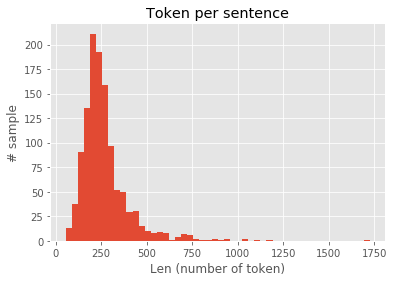

In [93]:
plt.hist([len(s[0]) for s in ds], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sample')
plt.show()

In [94]:
max([len(s[0]) for s in ds])

1727

In [103]:
for i, d in enumerate(ds):
    if len(d[0]) > 1000:
        print(i, d[0])

445 །དུས་བརྒྱ་ཟ་མ་གཅིག་ཡིན་དིང་རི་བ། །ཞེས་གསུངས། མདོར་ན་ཀུན་མཁྱེན་ཆོས་རྗེས། ཁོམ་ལྡན་མི་ཡི་འགྲོ་བ་རྙེད་གྱུར་ཅིང༌། །ཡང་དག་དགེ་བའི་བཤེས་དང་མཇལ་དུས་འདིར། །བདེ་འགྲོ་ཐར་པའི་སྐས་ལ་མ་འཛེགས་ན། །ཕྱིས་ནས་དལ་འབྱོར་ལུས་རྙེད་ཤིན་ཏུ་དཀའ། །དལ་དང་འབྱོར་བའི་མི་ལུས་མ་ཐོབ་ན། །སྡིག་པ་འབའ་ཞིག་མངོན་པར་འཕེལ་བ་ལས། །དགེ་གོམས་ཆོས་ལ་སྤྱོད་པའི་སྐབས་མི་རྙེད། །དམ་པའི་ཆོས་ཞེས་སྒྲ་ཡང་ཐོས་མི་འགྱུར། །དམ་པའི་ཆོས་དང་འཕྲད་པར་མ་གྱུར་ན། །སྡིག་པའི་དབང་གིས་འོག་ནས་འོག་ཏུ་འགྲོ། །ངན་སོང་གནས་ནས་ཐོན་པར་མ་གྱུར་ན། །སྔ་མའི་སྡུག་བསྔལ་དྲག་པོས་མནར་བཞིན་དུ། །ཕྱི་མའི་ལས་ངན་དཔག་མེད་སོག་པས་ན། །མུ་མཐའ་མེད་པའི་འཁོར་བར་རྟག་ཏུ་འཁྱམས། །མཐའ་མེད་སྡིག་པའི་རྒྱ་མཚོར་འཁྱམས་དུས་འདིར། །རང་རང་ལས་ཀྱི་རྦ་ཀློང་དྲག་པོས་འཁྲུགས། །སྡུག་བསྔལ་གཏིང་མཐའ་དཔག་ཏུ་མེད་པ་ལས། །ལས་ཟད་བར་དུ་ཡང་ཡང་བརྣག་དགོས་སོ། །རང་གི་ལས་ངན་འཁྲུལ་པའི་མེ་ཚོགས་ལ། །རྒྱལ་བའི་ཐུགས་རྗེས་དངོས་སུ་གཞིལ་དཀའ་སྟེ། །སྔོན་འདས་སངས་རྒྱས་གྲངས་མེད་བྱོན་ན་ཡང༌། །བདག་ཅག་ད་དུང་སྲིད་པར་འཁྱམས་ལ་ལྟོས། །དེ་བས་ད་ལྟ་དལ་འབྱོར་ཐོབ་དུས་འདིར། །འཁོར་བའི་སྡུག་བསྔལ་དཔག་མེད་བསམས་བྱས་ནས། །ཞི་བ་རབ་བཟང་ཐར་པའི་སྐྱེད་ཚལ་དུ། །དེ་རིང

In [97]:
test = '།ཤིན་ཏུ་འཕྲེང་{འཁྲེང}བའི་ནོར་དང་འཁོར་ལ་སོགས། །ཕངས་པ་མེད་པར་ཡོངས་སུ་གཏང་བར་བྱ། །རྒྱལ་བུ་སྙིང་སྟོབས་ཆེན་པོར་གྱུར་པ་ན། །སྟག་མོ་རང་གི་ཤ་ཡིས་གསོས་པ་ལྟར།'

for i, result in enumerate(json_01['result']):
    if test in result['example']['content']:
        print(i)

245
